### EDA Playground

- GUI 환경에서 dataset classes 선택시 해당하는 class별로 볼 수 있음
- anormaly - normal pair data를 찾아서 묶어준다음 idx별로 볼 수 있게 만듬.
- 스펙트로그램을 볼떄 n_fft 사이즈를 조절가능함. html로 따지면 range와 number input으로 조작가능
- 소리를 들을 수 있도록 재생 버튼도 있어야함


In [1]:
# -----------------------------
# Section 1: Imports
# -----------------------------
import os
import random
import uuid
import warnings
import base64
from io import BytesIO

import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.spatial.distance import cosine
from scipy.signal import welch, correlate, butter, sosfilt

from IPython.display import Audio, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, fixed
from skimage.metrics import structural_similarity as ssim

# Suppress warnings from librosa (optional)
warnings.filterwarnings('ignore')

# -----------------------------
# Section 2: Configuration
# -----------------------------
# Paths and directories
DATASETS_DIR = "../../../datasets/dev"  # Path to the datasets directory
HANDWRITE_CSV = os.path.join(DATASETS_DIR, "handwrite_notes.csv")

# Spectrogram parameters
N_FFT = 160
HOP_LENGTH_RATIO_OPTIONS = [1/2, 1/3, 1/4]

# Frequency bands configuration
PREDEFINED_BANDS = {}
START_FREQ = 100  # 0.1kHz
END_FREQ = 8000  # 8kHz
STEP_FREQ = 100  # 0.1kHz interval

current_freq = START_FREQ
while current_freq <= END_FREQ:
    label = f"{current_freq/1000:.1f} kHz"
    PREDEFINED_BANDS[label] = (current_freq, current_freq + STEP_FREQ)
    current_freq += STEP_FREQ

# Class names extracted from datasets directory
CLASS_NAMES = [
    name for name in os.listdir(DATASETS_DIR)
    if os.path.isdir(os.path.join(DATASETS_DIR, name))
]

# -----------------------------
# Section 3: Data Handling
# -----------------------------

def load_dataset(attributes_file: str, datasets_dir: str, class_name: str):
    """
    Load dataset file paths and labels from the attributes CSV.

    Parameters:
        attributes_file (str): Path to the attributes CSV file.
        datasets_dir (str): Base directory of the datasets.
        class_name (str): Name of the class to load.

    Returns:
        Tuple[List[str], List[str]]: Lists of file paths and corresponding labels.
    """
    if not os.path.isfile(attributes_file):
        raise FileNotFoundError(f"Attributes file not found: {attributes_file}")

    df = pd.read_csv(attributes_file)
    filenames = df['file_name'].tolist()
    labels = ['anomaly' if 'anomaly' in name.lower() else 'normal' for name in filenames]

    # Create file paths by combining datasets_dir and filename
    file_paths = [os.path.join(datasets_dir, f) for f in filenames]

    return file_paths, labels

def find_matching_normal_file(anomaly_path: str, normal_paths: list) -> str:
    """
    Find the corresponding normal file for a given anomaly file based on filename structure.

    Parameters:
        anomaly_path (str): Path to the anomaly file.
        normal_paths (List[str]): List of normal file paths.

    Returns:
        str or None: Path to the matching normal file or None if not found.
    """
    anomaly_filename = os.path.basename(anomaly_path)
    anomaly_parts = anomaly_filename.split("_")

    # Adjust indices according to your filename structure
    anomaly_number = anomaly_parts[5] if len(anomaly_parts) > 5 else None
    anomaly_code = anomaly_parts[6] if len(anomaly_parts) > 6 else None  # Adjusted index

    if anomaly_number is None:
        print(f"Unexpected file name format: {anomaly_filename}. No direct match found for anomaly file: {anomaly_path}")
        return None

    for normal_path in normal_paths:
        normal_filename = os.path.basename(normal_path)
        normal_parts = normal_filename.split("_")

        normal_number = normal_parts[5] if len(normal_parts) > 5 else None
        normal_code = normal_parts[6] if len(normal_parts) > 6 else None  # Adjusted index

        if anomaly_code is None:
            if anomaly_number == normal_number:
                return normal_path
        else:
            if anomaly_number == normal_number and anomaly_code == normal_code:
                return normal_path

    print(f"No direct match found for anomaly file: {anomaly_path}")
    return None

def compute_spectrogram(y: np.ndarray, n_fft: int, hop_length: int) -> np.ndarray:
    """
    Compute the magnitude spectrogram of an audio signal.

    Parameters:
        y (np.ndarray): Audio time series.
        n_fft (int): FFT window size.
        hop_length (int): Number of samples between successive frames.

    Returns:
        np.ndarray: Magnitude spectrogram.
    """
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_mag = np.abs(S)
    return S_mag

def compute_low_res_spectrogram(y: np.ndarray, sr: int, n_fft: int = 160, hop_length: int = 80, target_shape: tuple = (32, 32)) -> np.ndarray:
    """
    Compute a low-resolution spectrogram by downsampling.

    Parameters:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate.
        n_fft (int): FFT window size.
        hop_length (int): Number of samples between successive frames.
        target_shape (tuple): Desired shape of the spectrogram.

    Returns:
        np.ndarray: Low-resolution spectrogram.
    """
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_resized = librosa.util.fix_length(S, size=target_shape[0], axis=0)
    S_resized = librosa.util.fix_length(S_resized, size=target_shape[1], axis=1)
    return S_resized

def find_most_similar_normal_cosine(anomaly_spectrogram: np.ndarray, normal_spectrograms: list) -> tuple:
    """
    Find the most similar normal spectrogram to an anomaly spectrogram using cosine similarity.

    Parameters:
        anomaly_spectrogram (np.ndarray): Spectrogram of the anomaly.
        normal_spectrograms (List[Tuple[np.ndarray, str]]): List of tuples containing normal spectrograms and their file paths.

    Returns:
        Tuple[str, float]: Path to the most similar normal file and the similarity score.
    """
    max_similarity = -1
    most_similar_normal = None

    for normal_spectrogram, path in normal_spectrograms:
        similarity = 1 - cosine(anomaly_spectrogram.flatten(), normal_spectrogram.flatten())
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_normal = path

    return most_similar_normal, max_similarity

def load_notes(handwrite_csv: str) -> pd.DataFrame:
    """
    Load existing notes from the CSV file.

    Parameters:
        handwrite_csv (str): Path to the handwrite notes CSV.

    Returns:
        pd.DataFrame: DataFrame containing the notes.
    """
    if os.path.exists(handwrite_csv):
        df = pd.read_csv(handwrite_csv)
        # Replace NaN notes with empty strings
        df['anomaly_note'] = df['anomaly_note'].fillna('')
        df['normal_note'] = df['normal_note'].fillna('')
        df['common_note'] = df['common_note'].fillna('')
    else:
        df = pd.DataFrame(columns=['anomaly_path', 'normal_path', 'anomaly_note', 'normal_note', 'common_note'])
    return df

def save_note(handwrite_csv: str, anomaly_path: str, normal_path: str, anomaly_note: str, normal_note: str, common_note: str):
    """
    Save notes for a specific anomaly-normal pair to the CSV.

    Parameters:
        handwrite_csv (str): Path to the handwrite notes CSV.
        anomaly_path (str): Path to the anomaly file.
        normal_path (str): Path to the normal file.
        anomaly_note (str): Note for the anomaly.
        normal_note (str): Note for the normal.
        common_note (str): Common note for both.
    """
    df = load_notes(handwrite_csv)
    mask = (df['anomaly_path'] == anomaly_path) & (df['normal_path'] == normal_path)
    if mask.any():
        df.loc[mask, 'anomaly_note'] = anomaly_note
        df.loc[mask, 'normal_note'] = normal_note
        df.loc[mask, 'common_note'] = common_note
    else:
        print(f"Pair not found in CSV. Unable to save notes for anomaly: {anomaly_path} and normal: {normal_path}")
    df.to_csv(handwrite_csv, index=False)

def initialize_handwrite_csv(datasets_dir: str, handwrite_csv: str):
    """
    Initialize the handwrite_notes.csv with all anomaly-normal pairs and empty notes.

    Parameters:
        datasets_dir (str): Base directory of the datasets.
        handwrite_csv (str): Path to the handwrite notes CSV.
    """
    if os.path.exists(handwrite_csv):
        print(f"Handwrite CSV already exists at {handwrite_csv}. Skipping initialization.")
        return

    all_pairs = []

    for class_name in CLASS_NAMES:
        attributes_file = os.path.join(datasets_dir, class_name, "attributes_00.csv")
        try:
            file_paths, labels = load_dataset(attributes_file, datasets_dir, class_name)
        except FileNotFoundError as e:
            print(e)
            continue

        normal_paths = [path for path, label in zip(file_paths, labels) if label == 'normal']
        anomaly_paths = [path for path, label in zip(file_paths, labels) if label == 'anomaly']

        for anomaly_path in anomaly_paths:
            matching_normal_path = find_matching_normal_file(anomaly_path, normal_paths)
            if matching_normal_path:
                all_pairs.append({
                    'anomaly_path': anomaly_path,
                    'normal_path': matching_normal_path,
                    'anomaly_note': '',
                    'normal_note': '',
                    'common_note': ''
                })
            else:
                print(f"No matching normal found for anomaly: {anomaly_path}")

    # Create DataFrame and save to CSV
    df_pairs = pd.DataFrame(all_pairs)
    df_pairs.to_csv(handwrite_csv, index=False)
    print(f"Initialized handwrite CSV with {len(df_pairs)} pairs.")

# -----------------------------
# Section 4: Audio Processing
# -----------------------------

def apply_lowpass_filter(y: np.ndarray, sr: int, cutoff_freq: float) -> np.ndarray:
    """
    Apply a low-pass filter to the audio signal.

    Parameters:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate.
        cutoff_freq (float): Cutoff frequency in Hz.

    Returns:
        np.ndarray: Filtered audio signal.
    """
    sos = butter(10, cutoff_freq, btype='lowpass', fs=sr, output='sos')
    y_filtered = sosfilt(sos, y)
    return y_filtered

def apply_highpass_filter(y: np.ndarray, sr: int, cutoff_freq: float) -> np.ndarray:
    """
    Apply a high-pass filter to the audio signal.

    Parameters:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate.
        cutoff_freq (float): Cutoff frequency in Hz.

    Returns:
        np.ndarray: Filtered audio signal.
    """
    sos = butter(10, cutoff_freq, btype='highpass', fs=sr, output='sos')
    y_filtered = sosfilt(sos, y)
    return y_filtered

# -----------------------------
# Section 5: Plotting Utilities
# -----------------------------

def compute_and_plot_waveform(y: np.ndarray, sr: int, title: str):
    """Plot the waveform of the audio signal."""
    fig, ax = plt.subplots(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title(title)
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_envelope(y: np.ndarray, sr: int, title: str):
    """Plot the envelope of the audio signal."""
    envelope = np.abs(librosa.onset.onset_strength(y=y, sr=sr))
    times = librosa.times_like(envelope)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(times, envelope)
    ax.set_title(title)
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_cepstrum(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the cepstrum of the audio signal."""
    spectrum = np.fft.fft(y)
    log_spectrum = np.log(np.abs(spectrum) + 1e-10)
    cepstrum = np.fft.ifft(log_spectrum).real
    quefrency = np.arange(len(cepstrum)) / sr

    # Select quefrency range corresponding to frequency range
    idx = (quefrency >= 1 / max_freq) & (quefrency <= 1 / min_freq)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(quefrency[idx], cepstrum[idx])
    ax.set_title(title)
    ax.set_xlim(1 / max_freq, 1 / min_freq)
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_mel_spectrogram(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the Mel spectrogram of the audio signal."""
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots(figsize=(10, 3))
    librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    ax.set_title(title)
    ax.set_ylim([min_freq, max_freq])
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_mfcc(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float, normalization: str = "min-max"):
    """Plot the MFCCs of the audio signal with normalization."""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

    # Apply normalization
    if normalization == "min-max":
        mfccs_normalized = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs) + 1e-10)
    elif normalization == "z-score":
        mfccs_normalized = (mfccs - np.mean(mfccs)) / (np.std(mfccs) + 1e-10)
    else:
        raise ValueError("Unsupported normalization type. Use 'min-max' or 'z-score'.")

    # Plot the normalized MFCCs
    fig, ax = plt.subplots(figsize=(10, 3))
    librosa.display.specshow(mfccs_normalized, x_axis='time', ax=ax)
    ax.set_title(title)
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_chroma_features(y: np.ndarray, sr: int, title: str):
    """Plot the chroma features of the audio signal."""
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    fig, ax = plt.subplots(figsize=(10, 3))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax)
    ax.set_title(title)
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_spectral_centroid(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the spectral centroid of the audio signal."""
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    times = librosa.times_like(spectral_centroids)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.semilogy(times, spectral_centroids)
    ax.set_title(title)
    ax.set_ylabel('Hz')
    ax.set_ylim([min_freq, max_freq])
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_spectral_bandwidth(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the spectral bandwidth of the audio signal."""
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    times = librosa.times_like(spectral_bandwidth)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.semilogy(times, spectral_bandwidth)
    ax.set_title(title)
    ax.set_ylabel('Hz')
    ax.set_ylim([min_freq, max_freq])
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_wavelet_transform(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the wavelet transform of the audio signal."""
    try:
        import pywt
    except ImportError:
        raise ImportError("The 'pywt' library is required. Install it via 'pip install pywt'.")

    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(y, scales, 'morl', sampling_period=1/sr)
    fig, ax = plt.subplots(figsize=(10, 3))
    extent = [0, len(y)/sr, frequencies[-1], frequencies[0]]
    img = ax.imshow(np.abs(coefficients), extent=extent, cmap='PRGn', aspect='auto',
                    vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
    ax.set_title(title)
    ax.set_ylabel('Hz')
    ax.set_ylim([min_freq, max_freq])
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_power_spectrum(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the power spectrum of the audio signal."""
    S = np.abs(np.fft.fft(y))**2
    freqs = np.fft.fftfreq(len(y), 1/sr)
    idx = np.argsort(freqs)
    idx = idx[freqs[idx] >= 0]
    freqs = freqs[idx]
    S = S[idx]
    idx = (freqs >= min_freq) & (freqs <= max_freq)
    freqs = freqs[idx]
    S = S[idx]
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(freqs, S)
    ax.set_xlim([min_freq, max_freq])
    ax.set_title(title)
    ax.set_xlabel('Hz')
    plt.tight_layout(pad=0)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_psd(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the Power Spectral Density (PSD) of the audio signal."""
    freqs, psd = welch(y, sr)
    idx = (freqs >= min_freq) & (freqs <= max_freq)
    freqs = freqs[idx]
    psd = psd[idx]
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.semilogy(freqs, psd)
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD')
    ax.set_xlim([min_freq, max_freq])
    plt.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_spectral_flatness(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the spectral flatness of the audio signal."""
    S = np.abs(librosa.stft(y))
    flatness = librosa.feature.spectral_flatness(S=S)
    times = librosa.times_like(flatness[0], sr=sr)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(times, flatness[0])
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Spectral Flatness')
    ax.set_ylim([min(flatness[0]), max(flatness[0])])  # Adjust as needed
    plt.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    return fig, ax

def compute_and_plot_frequency_band_energy(y: np.ndarray, sr: int, title: str, min_freq: float, max_freq: float):
    """Plot the energy across defined frequency bands of the audio signal."""
    from scipy.signal import butter, sosfilt

    # Validate frequency bounds
    if min_freq < 0:
        raise ValueError("min_freq must be non-negative.")
    if max_freq <= min_freq:
        raise ValueError("max_freq must be greater than min_freq.")
    if max_freq > sr / 2:
        raise ValueError(f"max_freq cannot exceed Nyquist frequency (sr/2 = {sr/2} Hz).")

    # Define frequency bands
    bands = [
        (max(20, min_freq), 200),
        (200, 2000),
        (2000, max_freq)
    ]

    # Adjust bands based on min_freq
    if min_freq > 2000:
        bands = [(min_freq, max_freq)]
    elif 200 < min_freq <= 2000:
        bands = [
            (200, 2000),
            (2000, max_freq)
        ]
    elif 20 <= min_freq <= 200:
        bands = [
            (min_freq, 200),
            (200, 2000),
            (2000, max_freq)
        ]

    # Filter valid bands
    bands = [band for band in bands if band[1] <= max_freq and band[0] < band[1]]

    if not bands:
        print("No valid frequency bands defined within the specified min_freq and max_freq.")
        return None, None

    band_labels = [f'{int(band[0])}-{int(band[1])} Hz' for band in bands]
    band_energies = []

    for band in bands:
        low, high = band
        if low >= high:
            print(f"Invalid band with low={low} >= high={high}. Skipping.")
            band_energies.append(0)
            continue

        try:
            sos = butter(10, [low, high], btype='band', fs=sr, output='sos')
            filtered = sosfilt(sos, y)
            energy = np.sum(filtered ** 2)
            band_energies.append(energy)
        except ValueError as e:
            print(f"Error creating filter for band {band}: {e}")
            band_energies.append(0)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(band_labels, band_energies, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Energy')
    plt.tight_layout()
    return fig, ax

def compute_and_plot_autocorrelation(y: np.ndarray, sr: int, title: str):
    """Plot the autocorrelation of the audio signal."""
    autocorr = correlate(y, y, mode='full')
    lags = np.arange(-len(y)+1, len(y))
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(lags / sr, autocorr)
    ax.set_title(title)
    ax.set_xlabel('Lag (s)')
    ax.set_ylabel('Autocorrelation')
    plt.tight_layout()
    return fig, ax

# -----------------------------
# Section 6: Plot and Play Function
# -----------------------------

def plot_and_play_normal_anomaly_pair(
    anom_path: str,
    norm_path: str,
    n_fft: int,
    hop_length: int,
    min_freq: float,
    max_freq: float,
    include_ticks: bool,
    representation: str,
    filter_type: str = 'none',
    cutoff_freq: float = 2000.0
):
    """
    Plot and play the normal and anomaly audio pair with various representations.

    Parameters:
        anom_path (str): Path to the anomaly audio file.
        norm_path (str): Path to the normal audio file.
        n_fft (int): FFT window size.
        hop_length (int): Number of samples between successive frames.
        min_freq (float): Minimum frequency for plotting.
        max_freq (float): Maximum frequency for plotting.
        include_ticks (bool): Whether to include axis ticks in the plots.
        representation (str): Type of audio representation to plot.
        filter_type (str): Type of filter to apply ('none', 'lowpass', 'highpass').
        cutoff_freq (float): Cutoff frequency for the filter.
    """
    # Load audio files
    y_anomaly, sr_anomaly = librosa.load(anom_path, sr=None)
    y_normal, sr_normal = librosa.load(norm_path, sr=None)

    # Apply filtering if required
    if representation == 'linear_spectrogram' and filter_type != 'none':
        if filter_type == 'lowpass':
            y_anomaly_filtered = apply_lowpass_filter(y_anomaly, sr_anomaly, cutoff_freq)
            y_normal_filtered = apply_lowpass_filter(y_normal, sr_normal, cutoff_freq)
        elif filter_type == 'highpass':
            y_anomaly_filtered = apply_highpass_filter(y_anomaly, sr_anomaly, cutoff_freq)
            y_normal_filtered = apply_highpass_filter(y_normal, sr_normal, cutoff_freq)
    else:
        y_anomaly_filtered = y_anomaly
        y_normal_filtered = y_normal

    # Calculate durations
    duration_anomaly = len(y_anomaly_filtered) / sr_anomaly
    duration_normal = len(y_normal_filtered) / sr_normal

    # Extract filenames
    anomaly_filename = os.path.basename(anom_path)
    normal_filename = os.path.basename(norm_path)

    # Mapping of representation to plotting functions
    representation_mapping = {
        'waveform': compute_and_plot_waveform,
        'envelope': compute_and_plot_envelope,
        'cepstrum': compute_and_plot_cepstrum,
        'mel_spectrogram': compute_and_plot_mel_spectrogram,
        'mfcc': compute_and_plot_mfcc,
        'linear_spectrogram': None,  # Handled separately
        'chroma_features': compute_and_plot_chroma_features,
        'spectral_centroid': compute_and_plot_spectral_centroid,
        'spectral_bandwidth': compute_and_plot_spectral_bandwidth,
        'wavelet_transform': compute_and_plot_wavelet_transform,
        'power_spectrum': compute_and_plot_power_spectrum,
        'power_spectral_density': compute_and_plot_psd,
        'spectral_flatness': compute_and_plot_spectral_flatness,
        'frequency_band_energy': compute_and_plot_frequency_band_energy,
        'autocorrelation': compute_and_plot_autocorrelation
    }

    def generate_representation(y, sr, title):
        """Generate the specified audio representation plot."""
        if representation == 'linear_spectrogram':
            S = compute_spectrogram(y, n_fft, hop_length)
            S_db = librosa.amplitude_to_db(S, ref=np.max)
            fig, ax = plt.subplots(figsize=(10, 3))
            librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', ax=ax)
            ax.set_title(title)
            if not include_ticks:
                ax.set_xlabel('')
                ax.set_ylabel('')
                ax.tick_params(axis='both', which='both', length=0)
                ax.set_yticklabels([])
                ax.set_xticklabels([])
            ax.set_ylim([min_freq, max_freq])
            plt.tight_layout(pad=0)
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        else:
            plot_func = representation_mapping.get(representation)
            if plot_func:
                fig, ax = plot_func(y, sr, title, min_freq, max_freq)
            else:
                print(f"Unknown representation: {representation}")
                return None, None
        return fig, ax

    # Generate plots for anomaly and normal
    anomaly_title = f'Anomaly {representation.replace("_", " ").title()} - {anomaly_filename}'
    normal_title = f'Normal {representation.replace("_", " ").title()} - {normal_filename}'

    anomaly_fig, anomaly_ax = generate_representation(y_anomaly_filtered, sr_anomaly, anomaly_title)
    normal_fig, normal_ax = generate_representation(y_normal_filtered, sr_normal, normal_title)

    if anomaly_fig is None or normal_fig is None:
        print("Error generating representation.")
        return

    # Synchronize y-axis limits
    anomaly_ymax = anomaly_ax.get_ylim()[1]
    normal_ymax = normal_ax.get_ylim()[1]
    global_ymax = max(anomaly_ymax, normal_ymax)
    anomaly_ax.set_ylim(0, global_ymax)
    normal_ax.set_ylim(0, global_ymax)

    # Convert figure to data URI for HTML embedding
    def fig_to_data_uri(fig):
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        plt.close(fig)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        return 'data:image/png;base64,' + img_base64

    anomaly_img_uri = fig_to_data_uri(anomaly_fig)
    normal_img_uri = fig_to_data_uri(normal_fig)

    # Convert audio to data URI
    def audio_to_data_uri(y, sr):
        buf = BytesIO()
        sf.write(buf, y, sr, format='WAV')
        buf.seek(0)
        audio_base64 = base64.b64encode(buf.read()).decode('utf-8')
        return 'data:audio/wav;base64,' + audio_base64

    anomaly_audio_uri = audio_to_data_uri(y_anomaly_filtered, sr_anomaly)
    normal_audio_uri = audio_to_data_uri(y_normal_filtered, sr_normal)

    # Generate unique IDs for HTML elements
    anomaly_id = 'anomaly_' + str(uuid.uuid4()).replace('-', '')
    normal_id = 'normal_' + str(uuid.uuid4()).replace('-', '')

    # HTML template for displaying images and audio with interactive cursors
    html_template = """
    <div style="display: flex; flex-direction: column; align-items: center;">
        <label for="global_speed_select">Playback Speed:</label>
        <select id="global_speed_select" style="margin-bottom: 10px;">
            <option value="0.5">0.5x</option>
            <option value="0.75">0.75x</option>
            <option value="1.0" selected>1.0x</option>
            <option value="1.25">1.25x</option>
            <option value="1.5">1.5x</option>
            <option value="2.0">2.0x</option>
        </select>

        <div style="display: flex; align-items: center; margin-bottom: 20px;">
            <div style="position: relative; display: inline-block;">
                <img src="{anomaly_img_uri}" id="img_{anomaly_id}" style="display: block; margin: 0; padding: 0;" />
                <canvas id="cursor_canvas_{anomaly_id}" style="position: absolute; top: 0; left: 0;"></canvas>
            </div>
            <audio id="audio_{anomaly_id}" controls style="margin-left: 10px;">
                <source src="{anomaly_audio_uri}" type="audio/wav">
                Your browser does not support the audio element.
            </audio>
        </div>

        <div style="display: flex; align-items: center; margin-bottom: 20px;">
            <div style="position: relative; display: inline-block;">
                <img src="{normal_img_uri}" id="img_{normal_id}" style="display: block; margin: 0; padding: 0;" />
                <canvas id="cursor_canvas_{normal_id}" style="position: absolute; top: 0; left: 0;"></canvas>
            </div>
            <audio id="audio_{normal_id}" controls style="margin-left: 10px;">
                <source src="{normal_audio_uri}" type="audio/wav">
                Your browser does not support the audio element.
            </audio>
        </div>
    </div>
    <script>
    (function() {{
        var audioAnomaly = document.getElementById('audio_{anomaly_id}');
        var audioNormal = document.getElementById('audio_{normal_id}');
        var canvasAnomaly = document.getElementById('cursor_canvas_{anomaly_id}');
        var canvasNormal = document.getElementById('cursor_canvas_{normal_id}');
        var imgAnomaly = document.getElementById('img_{anomaly_id}');
        var imgNormal = document.getElementById('img_{normal_id}');
        var durationAnomaly = {duration_anomaly};
        var durationNormal = {duration_normal};

        var speedSelect = document.getElementById('global_speed_select');
        speedSelect.addEventListener('change', function() {{
            var playbackRate = parseFloat(this.value);
            audioAnomaly.playbackRate = playbackRate;
            audioNormal.playbackRate = playbackRate;
        }});

        function resizeCanvas(canvas, img) {{
            canvas.width = img.naturalWidth;
            canvas.height = img.naturalHeight;
            canvas.style.width = img.width + 'px';
            canvas.style.height = img.height + 'px';
        }}

        imgAnomaly.onload = function() {{
            resizeCanvas(canvasAnomaly, imgAnomaly);
        }};
        imgNormal.onload = function() {{
            resizeCanvas(canvasNormal, imgNormal);
        }};
        window.addEventListener('resize', function() {{
            resizeCanvas(canvasAnomaly, imgAnomaly);
            resizeCanvas(canvasNormal, imgNormal);
        }});

        function drawCursor(audio, canvas, duration) {{
            var ctx = canvas.getContext('2d');
            var currentTime = audio.currentTime;
            var x = (currentTime / duration) * canvas.width;
            ctx.clearRect(0, 0, canvas.width, canvas.height);
            ctx.beginPath();
            ctx.moveTo(x, 0);
            ctx.lineTo(x, canvas.height);
            ctx.strokeStyle = 'red';
            ctx.lineWidth = 2;
            ctx.stroke();

            if (!audio.paused) {{
                requestAnimationFrame(function() {{
                    drawCursor(audio, canvas, duration);
                }});
            }}
        }}

        audioAnomaly.addEventListener('play', function() {{
            requestAnimationFrame(function() {{
                drawCursor(audioAnomaly, canvasAnomaly, durationAnomaly);
            }});
        }});
        audioNormal.addEventListener('play', function() {{
            requestAnimationFrame(function() {{
                drawCursor(audioNormal, canvasNormal, durationNormal);
            }});
        }});

        audioAnomaly.addEventListener('pause', function() {{
            canvasAnomaly.getContext('2d').clearRect(0, 0, canvasAnomaly.width, canvasAnomaly.height);
        }});
        audioNormal.addEventListener('pause', function() {{
            canvasNormal.getContext('2d').clearRect(0, 0, canvasNormal.width, canvasNormal.height);
        }});

        audioAnomaly.addEventListener('seeked', function() {{
            drawCursor(audioAnomaly, canvasAnomaly, durationAnomaly);
        }});
        audioNormal.addEventListener('seeked', function() {{
            drawCursor(audioNormal, canvasNormal, durationNormal);
        }});
    }})();
    </script>
    """

    # Format the HTML with actual data
    combined_html = html_template.format(
        anomaly_img_uri=anomaly_img_uri,
        normal_img_uri=normal_img_uri,
        anomaly_audio_uri=anomaly_audio_uri,
        normal_audio_uri=normal_audio_uri,
        anomaly_id=anomaly_id,
        normal_id=normal_id,
        duration_anomaly=duration_anomaly,
        duration_normal=duration_normal
    )

    display(HTML(combined_html))

    # -----------------------------
    # Add Note Writing Widget
    # -----------------------------
    df_notes = load_notes(HANDWRITE_CSV)
    existing_anomaly_note = ""
    existing_normal_note = ""
    existing_common_note = ""
    mask = (df_notes['anomaly_path'] == anom_path) & (df_notes['normal_path'] == norm_path)
    if mask.any():
        existing_anomaly_note = df_notes.loc[mask, 'anomaly_note'].values[0] or ""
        existing_normal_note = df_notes.loc[mask, 'normal_note'].values[0] or ""
        existing_common_note = df_notes.loc[mask, 'common_note'].values[0] or ""

    # Text area widgets
    anomaly_note_text = widgets.Textarea(
        value=existing_anomaly_note,
        placeholder='Enter notes for anomaly data...',
        description='Anomaly Note:',
        layout=widgets.Layout(width='100%', height='60px'),
        disabled=False
    )

    normal_note_text = widgets.Textarea(
        value=existing_normal_note,
        placeholder='Enter notes for normal data...',
        description='Normal Note:',
        layout=widgets.Layout(width='100%', height='60px'),
        disabled=False
    )

    common_note_text = widgets.Textarea(
        value=existing_common_note,
        placeholder='Enter common notes...',
        description='Common Note:',
        layout=widgets.Layout(width='100%', height='60px'),
        disabled=False
    )

    # Save button widget
    save_button = widgets.Button(
        description='Save Notes',
        button_style='success',
        tooltip='Save your notes',
        icon='save'
    )

    # Output widget for notifications
    output = widgets.Output()

    # Button click handler
    def on_save_button_clicked(b):
        anomaly_note_content = anomaly_note_text.value
        normal_note_content = normal_note_text.value
        common_note_content = common_note_text.value
        save_note(HANDWRITE_CSV, anom_path, norm_path, anomaly_note_content, normal_note_content, common_note_content)
        # Display notification
        with output:
            print("Notes have been saved.")

    save_button.on_click(on_save_button_clicked)

    # Arrange the note text areas vertically
    notes_vbox = widgets.VBox([
        anomaly_note_text,
        normal_note_text,
        common_note_text
    ], layout=widgets.Layout(width='100%'))

    # Display the note section with vertical alignment
    display(widgets.VBox([
        widgets.HTML("<h3>Write Notes</h3>"),
        notes_vbox,
        save_button,
        output
    ]))

# -----------------------------
# Section 7: Interactive Widgets and Visualization
# -----------------------------

def interactive_visualization():
    """
    Setup and launch the interactive visualization using ipywidgets.
    """
    # Dropdown for selecting class
    class_dropdown = widgets.Dropdown(
        options=CLASS_NAMES,
        value=CLASS_NAMES[0],
        description='Class:',
        disabled=False,
    )

    # Slider for n_fft parameter
    n_fft_slider = widgets.IntSlider(
        value=N_FFT,
        min=32,
        max=512,
        step=4,
        description='n_fft:',
        continuous_update=False
    )

    # Dropdown for hop_length ratio
    hop_length_ratio_dropdown = widgets.Dropdown(
        options=HOP_LENGTH_RATIO_OPTIONS,
        value=1/2,
        description='Hop Ratio:',
        disabled=False
    )

    # Text input for index
    index_input = widgets.IntText(
        value=0,
        description='Index:',
        continuous_update=True,
        disabled=False
    )

    # Frequency range inputs
    min_freq_input = widgets.FloatText(
        value=0.0,
        description='Min Frequency (Hz):',
        continuous_update=False
    )

    max_freq_input = widgets.FloatText(
        value=8000.0,
        description='Max Frequency (Hz):',
        continuous_update=False
    )

    # Cutoff frequency input widget
    cutoff_freq_input = widgets.FloatText(
        value=2000.0,
        description='Cutoff Frequency (Hz):',
        continuous_update=False
    )

    # Filter buttons
    apply_lowpass_button = widgets.Button(
        description='Apply Low-pass Filter',
        tooltip='Apply low-pass filter to the audio'
    )
    apply_highpass_button = widgets.Button(
        description='Apply High-pass Filter',
        tooltip='Apply high-pass filter to the audio'
    )
    reset_filter_button = widgets.Button(
        description='Reset Filter',
        tooltip='Remove any applied filters'
    )

    # Buttons to set max frequency quickly
    max_freq_button_2000 = widgets.Button(description='2000 Hz', tooltip='Set max frequency to 2000 Hz')
    max_freq_button_4000 = widgets.Button(description='4000 Hz', tooltip='Set max frequency to 4000 Hz')
    max_freq_button_8000 = widgets.Button(description='8000 Hz', tooltip='Set max frequency to 8000 Hz')

    # Checkbox for including ticks
    include_ticks_checkbox = widgets.Checkbox(
        value=True,
        description='Include Ticks (linear spectrogram)',
        disabled=False
    )

    # Dropdown for selecting representation type
    representation_dropdown = widgets.Dropdown(
        options=[
            'waveform',
            'envelope',
            'cepstrum',
            'mel_spectrogram',
            'mfcc',
            'linear_spectrogram',
            'chroma_features',
            'spectral_centroid',
            'spectral_bandwidth',
            'wavelet_transform',
            'power_spectrum',
            'power_spectral_density',
            'spectral_flatness',
            'frequency_band_energy',
            'autocorrelation'
        ],
        value='linear_spectrogram',
        description='Representation:',
        disabled=False
    )

    # Output area for visualization
    out = widgets.Output()

    # Variable to keep track of the filter type
    filter_type_state = {'type': 'none'}

    # Event handlers for filter buttons
    def on_apply_lowpass_clicked(b):
        filter_type_state['type'] = 'lowpass'
        visualize(None)

    def on_apply_highpass_clicked(b):
        filter_type_state['type'] = 'highpass'
        visualize(None)

    def on_reset_filter_clicked(b):
        filter_type_state['type'] = 'none'
        visualize(None)

    apply_lowpass_button.on_click(on_apply_lowpass_clicked)
    apply_highpass_button.on_click(on_apply_highpass_clicked)
    reset_filter_button.on_click(on_reset_filter_clicked)

    # Event handlers for max frequency buttons
    def on_max_freq_button_click(freq_value):
        max_freq_input.value = freq_value

    max_freq_button_2000.on_click(lambda b: on_max_freq_button_click(2000))
    max_freq_button_4000.on_click(lambda b: on_max_freq_button_click(4000))
    max_freq_button_8000.on_click(lambda b: on_max_freq_button_click(8000))

    # Function to update index slider based on selected class
    def update_index_slider(*args):
        class_name = class_dropdown.value
        attributes_file = os.path.join(DATASETS_DIR, class_name, "attributes_00.csv")
        try:
            file_paths, labels = load_dataset(attributes_file, DATASETS_DIR, class_name)
            anomaly_paths = [path for path, label in zip(file_paths, labels) if label == 'anomaly']
            index_input.max = len(anomaly_paths) - 1 if len(anomaly_paths) > 0 else 0
        except FileNotFoundError:
            index_input.max = 0

    class_dropdown.observe(update_index_slider, names='value')
    update_index_slider()

    # Visualization function
    def visualize(change):
        with out:
            out.clear_output(wait=True)
            class_name = class_dropdown.value
            n_fft = n_fft_slider.value
            hop_ratio = hop_length_ratio_dropdown.value
            pair_index = index_input.value
            min_freq = min_freq_input.value
            max_freq = max_freq_input.value
            include_ticks = include_ticks_checkbox.value
            representation = representation_dropdown.value
            cutoff_freq = cutoff_freq_input.value

            # Validate cutoff frequency
            if cutoff_freq <= 0:
                print("Cutoff frequency must be positive.")
                return

            hop_length = int(n_fft * hop_ratio)
            attributes_file = os.path.join(DATASETS_DIR, class_name, "attributes_00.csv")

            # Validate frequency range
            if min_freq < 0:
                print("Min frequency must be non-negative.")
                return
            if max_freq <= min_freq:
                print("Max frequency must be greater than min frequency.")
                return

            try:
                file_paths, labels = load_dataset(attributes_file, DATASETS_DIR, class_name)
            except FileNotFoundError as e:
                print(e)
                return

            normal_paths = [path for path, label in zip(file_paths, labels) if label == 'normal']
            anomaly_paths = [path for path, label in zip(file_paths, labels) if label == 'anomaly']

            if pair_index >= len(anomaly_paths):
                print("Index out of range.")
                return

            anomaly_path = anomaly_paths[pair_index]
            print(f"Current anomaly file: {anomaly_path}")
            matching_normal_path = find_matching_normal_file(anomaly_path, normal_paths)

            if not matching_normal_path:
                print(f"No direct match found for anomaly file: {anomaly_path}")
                # Compute spectrograms for cosine similarity
                normal_spectrograms = []
                for path in normal_paths:
                    y_normal, sr_normal = librosa.load(path, sr=None)
                    S_normal = compute_spectrogram(y_normal, n_fft, hop_length)
                    normal_spectrograms.append((S_normal, path))
                y_anomaly, _ = librosa.load(anomaly_path, sr=None)
                S_anomaly = compute_spectrogram(y_anomaly, n_fft, hop_length)
                matching_normal_path, max_similarity = find_most_similar_normal_cosine(S_anomaly, normal_spectrograms)
                print(f"Most similar normal file: {matching_normal_path} (similarity: {max_similarity})")
            else:
                print(f"Matching normal file: {matching_normal_path}")

            # Plot and play the pair
            plot_and_play_normal_anomaly_pair(
                anomaly_path,
                matching_normal_path,
                n_fft,
                hop_length,
                min_freq,
                max_freq,
                include_ticks,
                representation,
                filter_type_state['type'],  # Pass the filter type
                cutoff_freq                  # Pass the cutoff frequency
            )

    # Register event handlers
    class_dropdown.observe(visualize, names='value')
    n_fft_slider.observe(visualize, names='value')
    hop_length_ratio_dropdown.observe(visualize, names='value')
    index_input.observe(visualize, names='value')
    min_freq_input.observe(visualize, names='value')
    max_freq_input.observe(visualize, names='value')
    include_ticks_checkbox.observe(visualize, names='value')
    representation_dropdown.observe(visualize, names='value')

    # Initial visualization
    visualize(None)

    # Layout for frequency controls
    freq_controls = widgets.HBox([
        max_freq_input,
        widgets.VBox([
            max_freq_button_2000,
            max_freq_button_4000,
            max_freq_button_8000
        ])
    ])

    # Layout for filter controls
    filter_controls = widgets.HBox([
        cutoff_freq_input,
        apply_lowpass_button,
        apply_highpass_button,
        reset_filter_button
    ])

    # Assemble the UI
    ui = widgets.VBox([
        class_dropdown,
        widgets.HBox([n_fft_slider, hop_length_ratio_dropdown]),
        freq_controls,
        index_input,
        widgets.HBox([representation_dropdown, include_ticks_checkbox]),
        filter_controls
    ])

    # Display the UI and output
    display(ui, out)

# -----------------------------
# Section 8: Main Execution
# -----------------------------
if __name__ == "__main__":
    # Step 1: Initialize the handwrite_notes.csv with all pairs and empty notes
    initialize_handwrite_csv(DATASETS_DIR, HANDWRITE_CSV)
    
    # Step 2: Launch the interactive visualization
    interactive_visualization()


Handwrite CSV already exists at ../../../datasets/dev/handwrite_notes.csv. Skipping initialization.


Output()

### Vision LLM을 통해 EDA가 가능할까?

anomaly와 normal에 대해서 계속해서 비교 분석중..

![alt text](image.png)

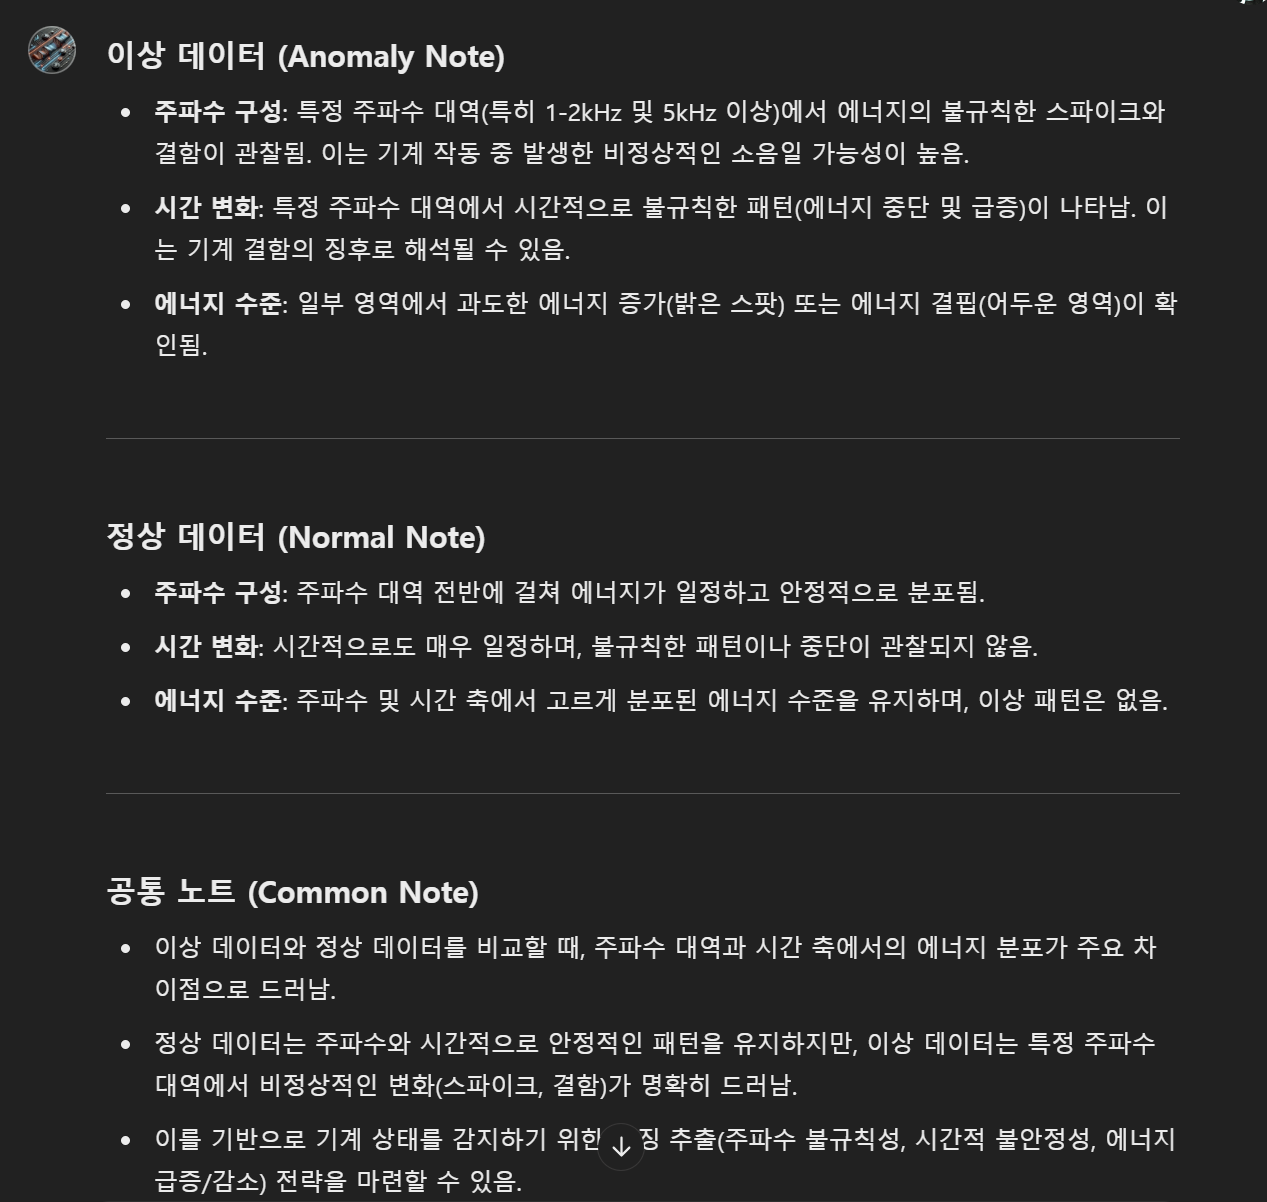